In [1]:
# import pvlib and other useful python packages
import pvlib
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# a "typical meteorological year" or TMY is made of individual months
# cherry picked from several years, but to run a simulation we need
# to calculate solar positions for an actual year. EG: PVsyst defaults
# to 1990
YEAR = 1990
STARTDATE = '%d-01-01T00:00:00' % YEAR
ENDDATE = '%d-12-31T23:59:59' % YEAR
TIMES = pd.date_range(start=STARTDATE, end=ENDDATE, freq='H')

In [3]:
# pvlib python can retrieve CEC module and inverter parameters from the
# SAM libraries
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')
INVERTERS = pvlib.pvsystem.retrieve_sam('CECInverter')

# It can be tricky to find the modules you want so you can visit their
# GitHub page to search the CSV files manually, or use pvfree
# https://pvfree.herokuapp.com/cec_modules/ and ditto for inverters
# https://pvfree.herokuapp.com/pvinverters/
# NOTE: whitespace, hyphens, dashes, etc. are replaced by underscores
# These are some basic 300-W Canadian Solar poly and mono Si modules
CECMOD_POLY = CECMODS['Canadian_Solar_Inc__CS6X_300P']
CECMOD_MONO = CECMODS['Canadian_Solar_Inc__CS6X_300M']

In [4]:
# here's a trick, transpose the database, and search the index using
# strings
INVERTERS.T[INVERTERS.T.index.str.startswith('SMA_America__STP')]
#                                       Vac         Pso     Paco  ... Mppt_high    CEC_Date             CEC_Type
# SMA_America__STP_33_US_41__480V_      480  126.152641  33300.0  ...     800.0         NaN  Utility Interactive
# SMA_America__STP_50_US_41__480V_      480  111.328354  50010.0  ...     800.0    1/2/2019  Utility Interactive
# SMA_America__STP_60_US_10__400V_      400   97.213982  59860.0  ...     800.0         NaN  Utility Interactive
# SMA_America__STP_60_US_10__480V_      480  116.969749  60000.0  ...     800.0         NaN  Utility Interactive
# SMA_America__STP_62_US_41__480V_      480  133.166687  62500.0  ...     800.0         NaN  Utility Interactive
# SMA_America__STP12000TL_US_10__480V_  480   56.013401  12000.0  ...     800.0  10/15/2018  Utility Interactive
# SMA_America__STP15000TL_US_10__480V_  480   52.128044  15000.0  ...     800.0  10/15/2018  Utility Interactive
# SMA_America__STP20000TL_US_10__480V_  480   46.517708  20000.0  ...     800.0  10/15/2018  Utility Interactive
# SMA_America__STP24000TL_US_10__480V_  480   46.893803  24060.0  ...     800.0  10/15/2018  Utility Interactive
# SMA_America__STP30000TL_US_10__480V_  480    62.93433  30010.0  ...     800.0  10/15/2018  Utility Interactive
# SMA_America__STP50_US_40__480V_       480  125.080681  50072.0  ...     800.0  10/15/2018  Utility Interactive

# that was almost too easy, let's use the 60-kW Sunny TriPower, it's a good inverter.
INVERTER_60K = INVERTERS['SMA_America__STP_60_US_10__480V_']

In [5]:
# I know we already did this in the other tutorials, but now we have
# to do it again, sorry. Think of it as a review or pop quiz
# we need to get:
# * weather
# * solar position
# * PV surface orientation, aoi, etc.
# * plane of array irradiance
# * module temperatures
# but first we need to know where in the world are we?
LATITUDE, LONGITUDE = 40.5137, -108.5449

In [8]:
# now we can get some weather, before we used TMY,
# now we'll get some data from PVGIS
data, months, inputs, meta = pvlib.iotools.get_pvgis_tmy(latitude=LATITUDE, longitude=LONGITUDE)

In [9]:
# get solar position
data.index = TIMES
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values

In [10]:
# get tracker positions
tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
surface_tilt = tracker['surface_tilt']
surface_azimuth = tracker['surface_azimuth']
aoi = tracker['aoi']

In [16]:
# get irradiance
dni = data['dni'].values
ghi = data['ghi'].values
dhi = data['dhi'].values
surface_albedo = 0.25
temp_air = data['temp_air'].values
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

# we use the Hay Davies transposition model
poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi, albedo=surface_albedo)
poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
poa_direct = poa['poa_direct']
poa_diffuse = poa['poa_diffuse']
poa_global = poa['poa_global']
iam = pvlib.iam.ashrae(aoi)
effective_irradiance = poa_direct*iam + poa_diffuse

In [17]:
# module temperature
temp_cell = pvlib.temperature.pvsyst_cell(poa_global, temp_air)

In [18]:
# finally this is the magic
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        CECMOD_MONO.alpha_sc, CECMOD_MONO.a_ref,
        CECMOD_MONO.I_L_ref, CECMOD_MONO.I_o_ref,
        CECMOD_MONO.R_sh_ref, CECMOD_MONO.R_s, CECMOD_MONO.Adjust)
mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
mpp = pd.DataFrame(mpp, index=TIMES)

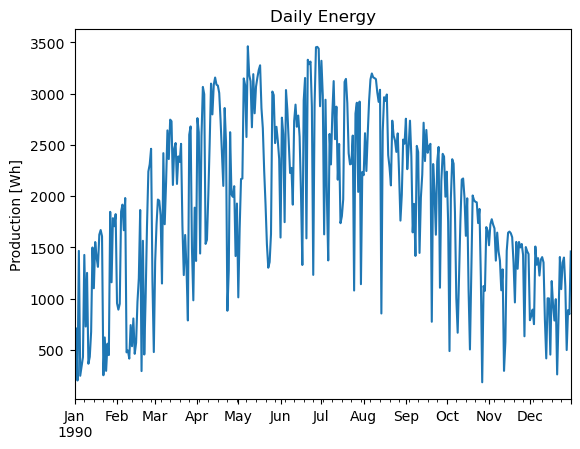

In [19]:
# the goods
mpp.p_mp.resample('D').sum().plot(title='Daily Energy')
plt.ylabel('Production [Wh]');

In [20]:
temp_ref = 25.0  # degC
dc_ac = 1.3
# maximum open circuit voltage
MAX_VOC = CECMOD_MONO.V_oc_ref + CECMOD_MONO.beta_oc * (temp_air.min() - temp_ref)
STRING_LENGTH = int(INVERTER_60K['Vdcmax'] // MAX_VOC)
STRING_VOLTAGE = STRING_LENGTH * MAX_VOC
STRING_OUTPUT = CECMOD_MONO.STC * STRING_LENGTH
STRING_COUNT = int(dc_ac * INVERTER_60K['Paco'] // STRING_OUTPUT)
DC_CAPACITY = STRING_COUNT * STRING_OUTPUT
DCAC = DC_CAPACITY / INVERTER_60K['Paco']
MAX_VOC, STRING_LENGTH, STRING_VOLTAGE, STRING_OUTPUT, STRING_COUNT, DC_CAPACITY, DCAC

(52.2110052, 15, 783.165078, 4500.45, 17, 76507.65, 1.2751275)

In [21]:
EDAILY = mpp.p_mp * STRING_LENGTH * STRING_COUNT
AC_OUTPUT = pvlib.inverter.sandia(
    mpp.v_mp * STRING_LENGTH,
    mpp.p_mp * STRING_LENGTH * STRING_COUNT,
    INVERTER_60K)
AC_OUTPUT.max()

60000.0

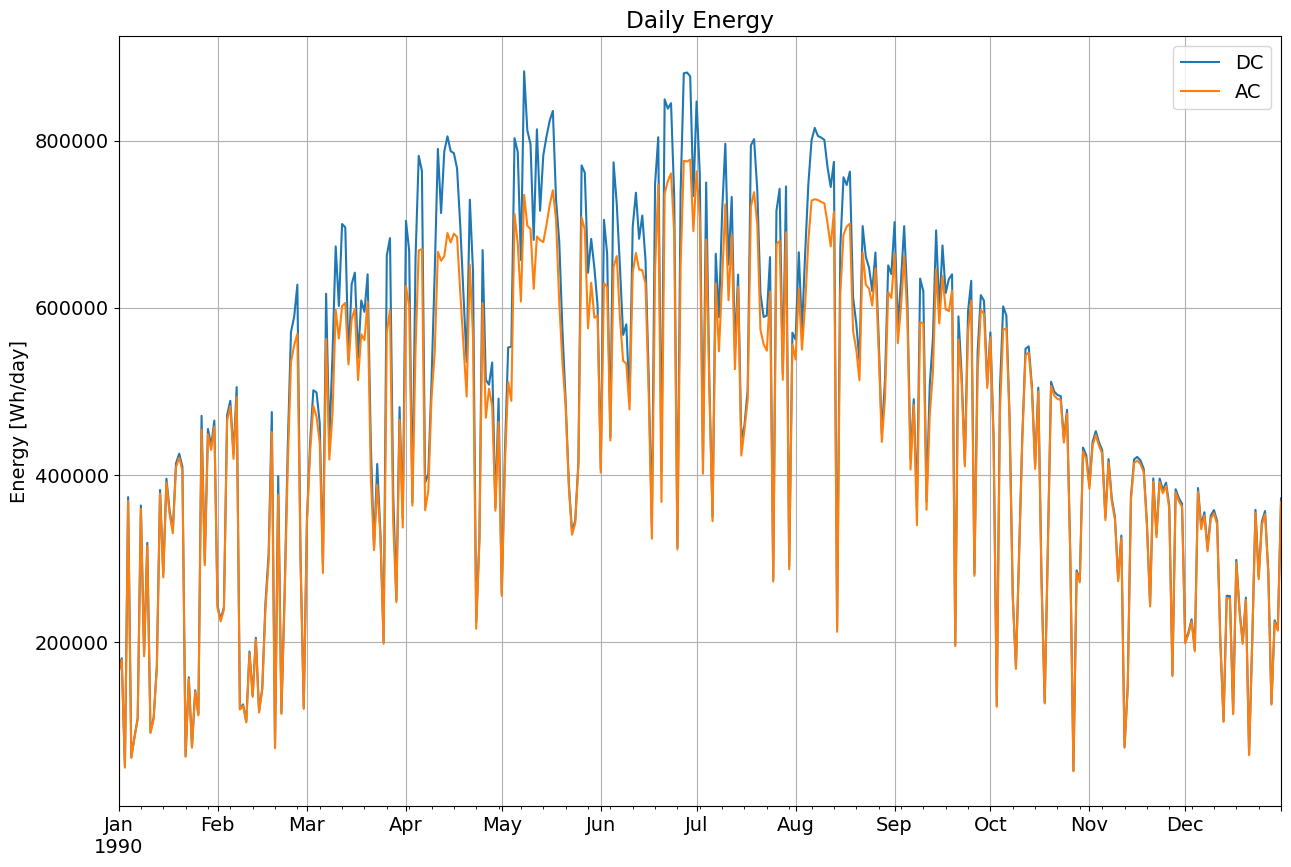

In [22]:
# the goods
plt.rcParams['font.size'] = 14
ax = EDAILY.resample('D').sum().plot(figsize=(15, 10), label='DC', title='Daily Energy')
AC_OUTPUT.resample('D').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/day]')
plt.legend()
plt.grid()